In [1]:
import matplotlib.pyplot as plt
from scipy.io import readsav
import numpy as np
import copy
from helita.io import lp
from astropy.io import fits
import cv2
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, medial_axis

In [2]:
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'
dpath_area = '/mn/stornext/d9/souvikb/K_means_results/savefiles/'
dpath_cluster_fits= '/mn/stornext/d9/souvikb/K_means_results/'
dpath_timesteps ='/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/calib_tseries/'

In [3]:
cluster_mask = fits.getdata(dpath_cluster_fits+'clusters_mask.fits',ext=0)# Reading the Cluster mask time series
#Statistics computed from the previous analysis.
stats_rbe = readsav(dpath_area+'RBE_full_stats.sav')
labels = stats_rbe['labels_rbe']
area = stats_rbe['area_rbe']
life = stats_rbe['lifetime_rbe']
lab_cube = stats_rbe['lab_full_rbe']
#Reading the La Palma cubes##
hdrH_im =lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
hdrH_sp = lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])
time_sst = readsav(dpath_timesteps+'tseries_3950_2017-05-25T09:12:00_scans=0-424_calib.sav')
time_sst=time_sst['time']

/astro/local/anaconda/lib/python3.7/site-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


In [4]:
#kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#cluster_interest=[34,17,32,35,12,49,25,48]# This is the set of clusters prevalent in the footpoints of most RBEs. I have not investigated RREs. Update: added 8 amd 21
cluster_interest_blu =[12,49,25,48] #added 5 and 11 based on COG technique
master_aux_cube=cluster_mask*0.
skel = cluster_mask*0.
for clust_index in range(len(cluster_interest_blu)):
    master_aux_cube[np.where(cluster_mask == cluster_interest_blu[clust_index])] = 1.
#for time in range(425):
#    skel[:,:,time] = skeletonize(master_aux_cube[:,:,time],method='zhang') #Skeletonizing images in 2D for each time

In [23]:
#labelling the images: skeleton or no skeleton
#labelled_skeleton = label(skel,return_num=True, connectivity=None)
labelled_skeleton = label(master_aux_cube,return_num=True,connectivity=2)#Connectivity =1 signifies 4 point connectivity and 2 signifies 8 point connectivity
print(labelled_skeleton[1])


32842


In [9]:
(rows,cols)= np.nonzero(labelled_skeleton[0][:,:,165])
skel_coords =[]
for (r,c) in zip(rows,cols):
    (col_neigh,row_neigh)=np.meshgrid(np.array([c-1,c,c+1]), np.array([r-1,r,r+1]))
    col_neigh = col_neigh.astype('int')
    row_neigh = row_neigh.astype('int')
    pix_neighbor = labelled_skeleton[0][row_neigh,col_neigh].ravel()!= 0
    if np.sum(pix_neighbor)==2:
        skel_coords.append((r,c))

In [19]:
skel_coords

[(506, 292), (813, 141), (1313, 450), (1389, 854)]

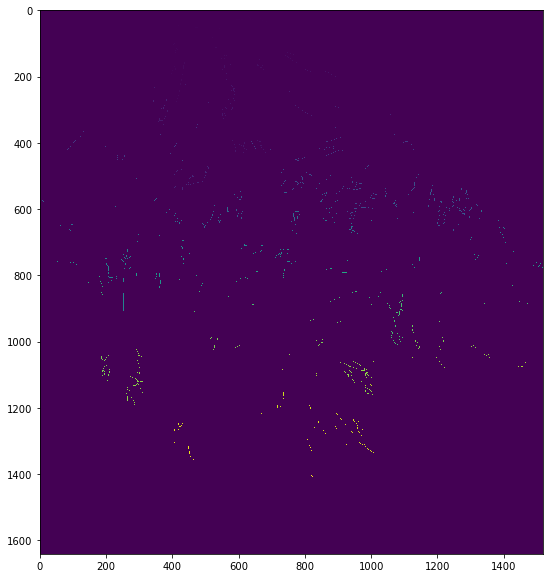

In [21]:
plt.figure(figsize=(10,10))
 
plt.imshow(labelled_skeleton[0][:,:,165])

In [24]:
#Computing the area, eccenticity, length per label per unit time 
length = np.zeros((labelled_skeleton[1],425))
eccentricity = length*0.
area = length*0.
for time in range(425):
    for region in regionprops(labelled_skeleton[0][:,:,time]):
        lab = region.label-1
        length[lab,time]=region.major_axis_length #using the lab as an index of my matrix
        eccentricity[lab,time] = region.eccentricity
        area[lab,time] = region.area
        #print(lab)


In [25]:
#Selecting the maximum length of each label and the corresponding eccentricities and area for that label. 
lab_no = np.zeros((labelled_skeleton[1]))
max_length = lab_no*0.
eccen = np.zeros((labelled_skeleton[1]))
area_max = eccen*0.
for i in range(labelled_skeleton[1]):
    lab_no[i] = i+1
    max_length[i] = np.max(length[i,:])*0.037*0.722 #Converting to Mm
    index_max=np.where(length[i,:] == np.amax(length[i,:]))
    eccen[i] = eccentricity[i,index_max[0][0]]
    area_max[i]=area[i,index_max[0][0]]*0.037*0.037

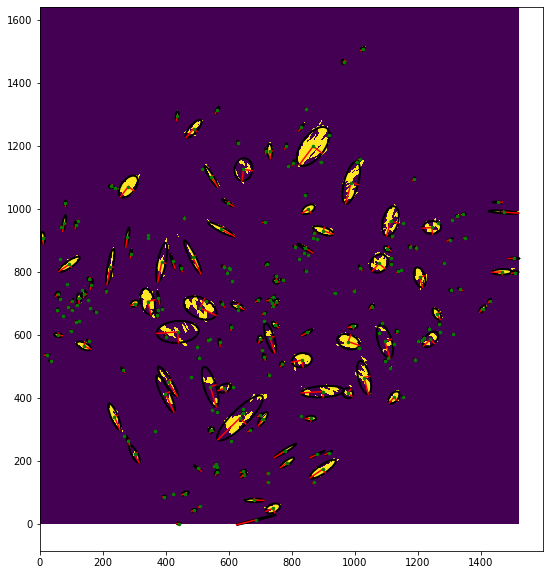

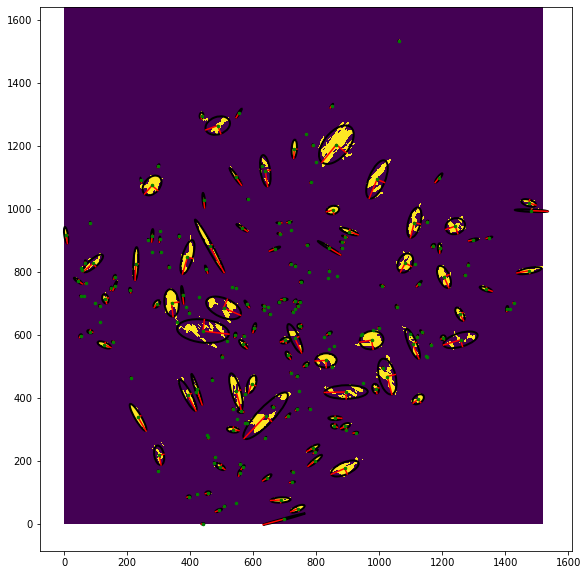

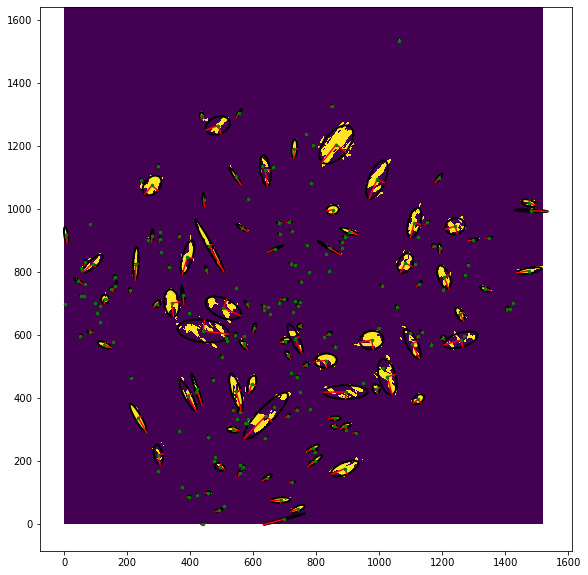

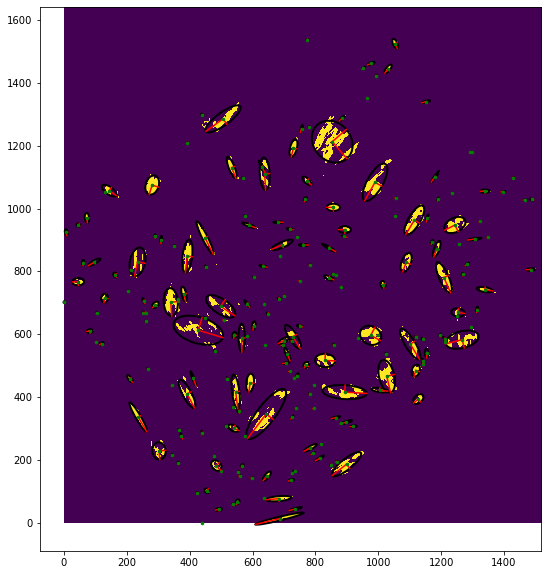

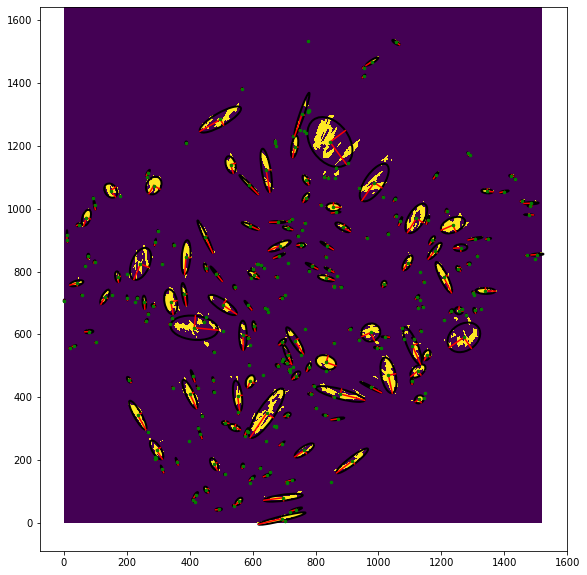

In [26]:
#Showing the ellipse detection for a set of images. 
import math
import matplotlib.patches as mpatches
for time in range(5):   
    time =time+0
    fig, ax = plt.subplots(figsize=(10, 10))
    mask_2d = labelled_skeleton[0][:,:,time]*0
    mask_2d[np.where(labelled_skeleton[0][:,:,time]!=0)]=1.
    #ax.imshow(master_aux_cube[500:1000,:500,time])
    ax.imshow(mask_2d,origin='lower')
    for region in regionprops(labelled_skeleton[0][:,:,time]):      
        y0,x0 = region.centroid
        orientation = region.orientation
        angle = math.degrees(orientation)
        x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
        ax.plot((x0, x1), (y0, y1), '-r')
        ax.plot((x0, x2), (y0, y2), '-r')
        ax.plot(x0, y0, '.g', markersize=5)
        ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                      fill=False, edgecolor='black', linewidth=2,angle=-angle)
        ax.add_patch(ellipse)
  #  plt.savefig('/mn/stornext/u3/souvikb/paper4_images/Detections/Ellipse-'+str(time)+'.png',dpi=600,orientation='landscape')
    plt.show()


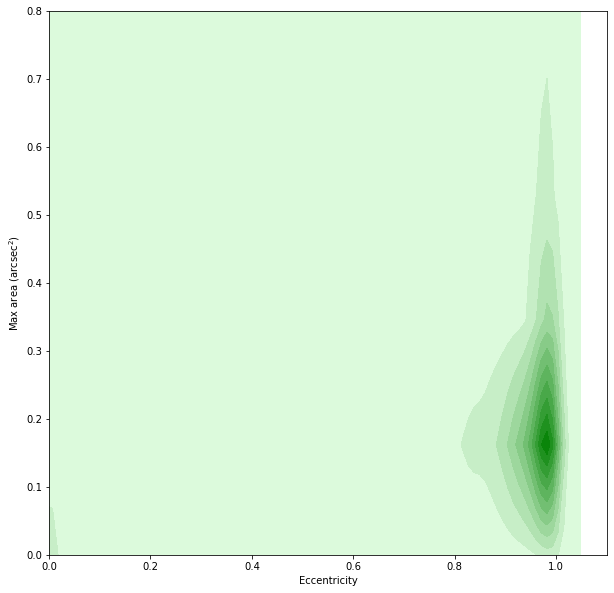

In [27]:
#Data visualization: KDEs, 2D histograms, 1D histograms for eccentricities and length
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set(yscale="log",xscale='log')
h = sns.kdeplot(eccen,data2=area_max,shade=True,ax=ax,color='green',bw='scott')
#h = sns.regplot(x=eccen,y=max_length,ax=ax,scatter_kws={"alpha":0.05})
ax.set_xlim(0.,1.1)
ax.set_ylim(0,0.8)
ax.set_xlabel('Eccentricity')
ax.set_ylabel(r'Max area (arcsec$^{2}$)')
plt.show()

Text(0, 0.5, 'Frequency')

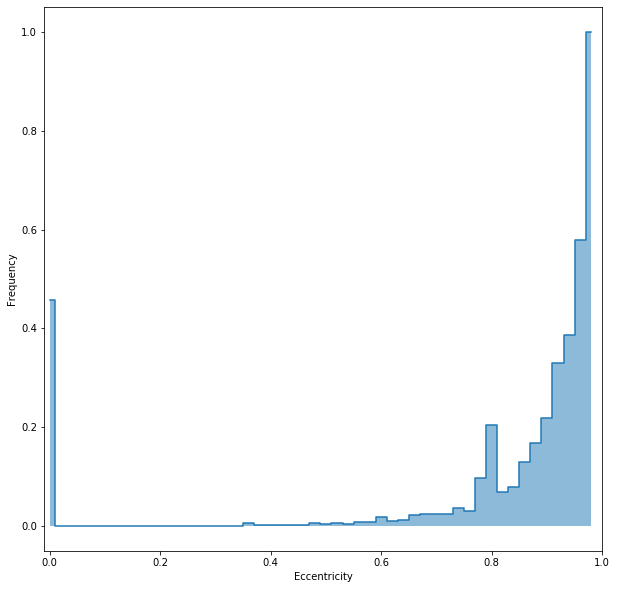

In [28]:
n, bins = np.histogram(eccen, 50)
n = n/n.max()
bins = bins[:-1]
plt.figure(figsize=(10,10))
plt.plot(bins, n,drawstyle='steps-mid')
plt.fill_between(bins,n,step='mid',alpha=0.5)
plt.xlim(-0.01,1)
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

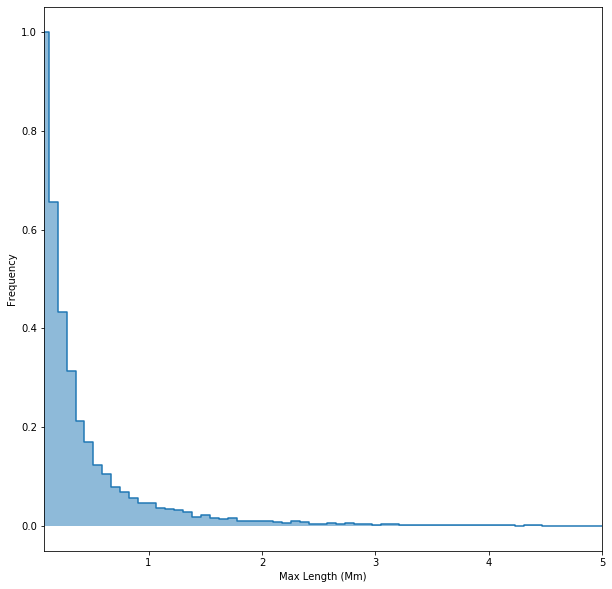

In [29]:
n1, bins1 = np.histogram(max_length, 150)
n1 = n1/n1.max()
bins1 = bins1[:-1]
plt.figure(figsize=(10,10))
plt.plot(bins1, n1,drawstyle='steps-mid')
plt.fill_between(bins1,n1,step='mid',alpha=0.5)
plt.xlim(0.08,5)
plt.xlabel('Max Length (Mm)')
plt.ylabel('Frequency')

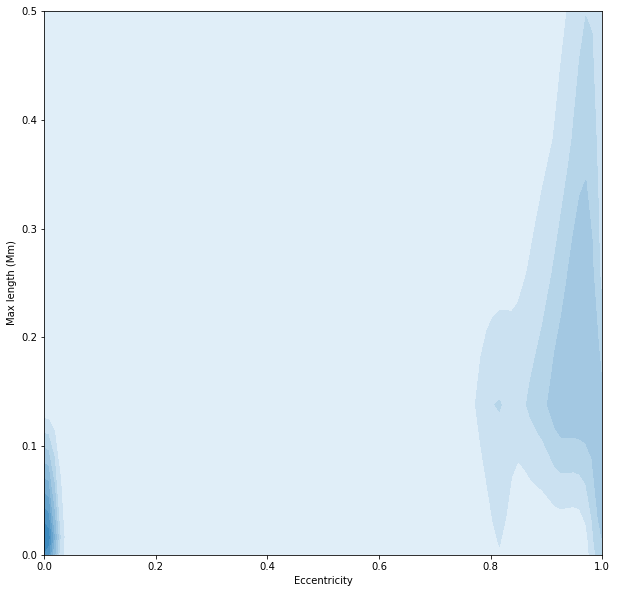

In [30]:
#Data visualization: KDEs, 2D histograms, 1D histograms for eccentricities and length
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set(yscale="log",xscale='log')
h = sns.kdeplot(eccen,data2=max_length,shade=True,ax=ax,bw='scott')
#h = sns.regplot(x=eccen,y=max_length,ax=ax,scatter_kws={"alpha":0.05})
ax.set_xlim(0,1)
ax.set_ylim(0,0.5)
ax.set_xlabel('Eccentricity')
ax.set_ylabel(r'Max length (Mm)')
plt.show()

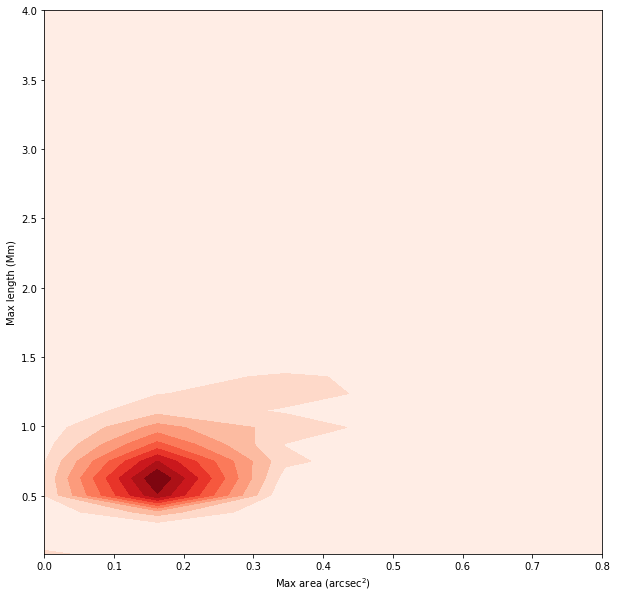

In [31]:
#Data visualization: KDEs, 2D histograms, 1D histograms for eccentricities and length
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set(yscale="log",xscale='log')
h = sns.kdeplot(area_max,data2=max_length,shade=True,cmap='Reds',ax=ax,bw='scott')
#h = sns.regplot(x=eccen,y=max_length,ax=ax,scatter_kws={"alpha":0.05})
ax.set_xlim(0,0.8)
ax.set_ylim(0.08,4)
ax.set_xlabel(r'Max area (arcsec$^{2}$)')
ax.set_ylabel(r'Max length (Mm)')
plt.show()

(-0.01, 2)

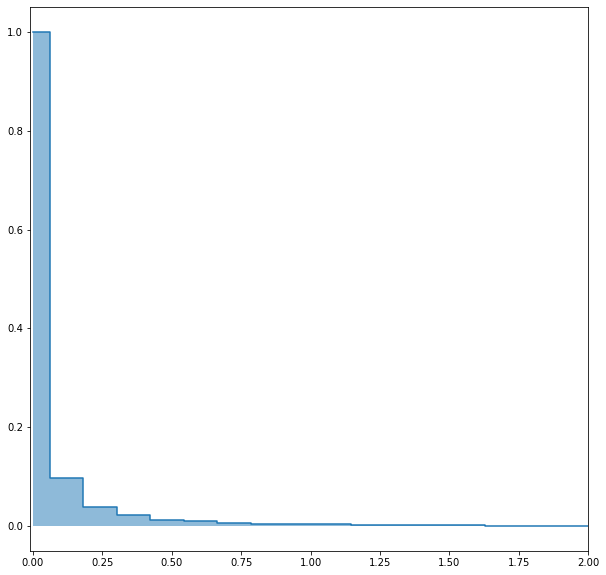

In [27]:
n2, bins2 = np.histogram(area_max, 150)
n2 = n2/n2.max()
bins2 = bins2[:-1]
plt.figure(figsize=(10,10))
plt.plot(bins2, n2,drawstyle='steps-mid')
plt.fill_between(bins2,n2,step='mid',alpha=0.5)
plt.xlim(-0.01,2)

(-0.01, 2)

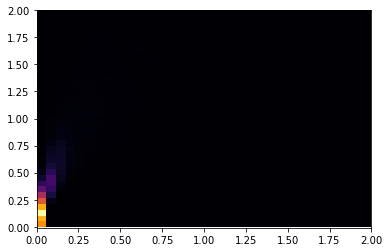

In [13]:
plt.hist2d(area_max,max_length,bins=(150,150),cmap='inferno')
plt.xlim(0.0,2)
plt.ylim(-0.01,2)


(-0.01, 1)

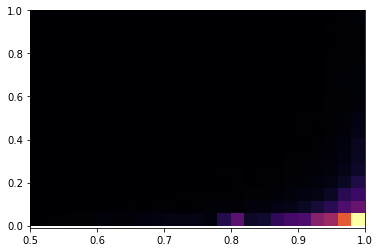

In [12]:
plt.hist2d(eccen,area_max,bins=(50,150),cmap='inferno')
plt.xlim(0.5,1)
plt.ylim(-0.01,1)

In [32]:
res1= np.where(eccen >= 0.8)

In [33]:
res1[0][:]

array([    0,     1,     5, ..., 32839, 32840, 32841])

(array([9.066e+03, 5.211e+03, 3.177e+03, 1.951e+03, 1.325e+03, 9.490e+02,
        7.430e+02, 5.580e+02, 4.500e+02, 3.830e+02, 3.390e+02, 2.530e+02,
        2.070e+02, 1.650e+02, 1.590e+02, 1.130e+02, 1.070e+02, 1.080e+02,
        8.000e+01, 9.500e+01, 5.300e+01, 5.200e+01, 5.200e+01, 4.700e+01,
        4.500e+01, 3.700e+01, 3.900e+01, 3.200e+01, 1.900e+01, 2.500e+01,
        1.700e+01, 2.500e+01, 1.400e+01, 2.000e+01, 1.600e+01, 1.400e+01,
        1.400e+01, 1.200e+01, 1.100e+01, 1.000e+01, 7.000e+00, 1.100e+01,
        6.000e+00, 1.000e+01, 9.000e+00, 4.000e+00, 6.000e+00, 5.000e+00,
        8.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 6.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+0

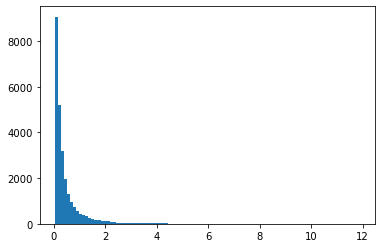

In [34]:
plt.hist(max_length[res1[0][:]],bins=100)